<a href="https://colab.research.google.com/github/gitflai/MinicursoFLAIDataScienceNaCopa/blob/main/Minicurso_FLAI_Data_Science_na_Copa_do_Mundo_Qatar_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Qatar 2022 World Cup project ⚽**

Hi! In this notebook I will perform two main tasks: first, to predict the Cup's games: winner and loser, and second, to predict the entire World Cup result. So, without further ado, lets begin!

Lets start by loading our libraries and our data set. See you in a bit!

In [2]:
# first things first, lets start by calling our libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson # main probability function used for these kind of events

#### Loading dataset

In [29]:
# the .xlsx has many sheets, so we have to select the desired one

teams = pd.read_excel('data/DadosCopaDoMundoQatar2022.xlsx',
                        sheet_name ='selecoes',
                        names = ['Teams_BR',
                                 'Group',
                                 'GroupNumber',
                                 'Team',
                                 'FIFAsRankPosition',
                                 'MarketValue',
                                 'FIFAsRankingPoints',
                                 'Confederation',
                                 'WorldCups',
                                 'SpotlightPlayer',
                                 'PictureOfPlayer',
                                 'FlagsLinkSmall',
                                 'FlagsLinksBig'],
                        index_col = 0) # tells that column 0 will give the row indexes to look neat

games = pd.read_excel('data/DadosCopaDoMundoQatar2022.xlsx', sheet_name ='jogos')


In [30]:
teams.head()

,Group,GroupNumber,Team,FIFAsRankPosition,MarketValue,FIFAsRankingPoints,Confederation,WorldCups,SpotlightPlayer,PictureOfPlayer,FlagsLinkSmall,FlagsLinksBig
Teams_BR,,,,,,,,,,,,
Catar,A,A1,Qatar,48,18.33,1442,AFC,0,Almoez Ali,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Equador,A,A2,Ecuador,44,125.80,1464,UEFA,0,Pervis Estupiñán,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Senegal,A,A3,Senegal,18,286.50,1585,CAF,0,Sadio Mané,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Holanda,A,A4,Netherlands,8,455.75,1679,UEFA,0,Virgil Van Dijk,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Inglaterra,B,B1,England,5,1360.00,1737,UEFA,1,Harry Kane,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...


In [31]:
games.head()

,data,hora,grupo,seleção1,seleção2,estádio
0,2022-11-21,07:00:00,A,Senegal,Holanda,AL THUMAMA
1,2022-11-21,13:00:00,A,Catar,Equador,AL KHOR
2,2022-11-25,10:00:00,A,Catar,Senegal,AL THUMAMA
3,2022-11-25,13:00:00,A,Holanda,Equador,INTER. KHALIFA
4,2022-11-29,12:00:00,A,Holanda,Catar,AL KHOR


Okay! All good to go. But now we have two problems to solve. The **first one** is: How model a team's goals distribution for a match? And the **second one**: how figure it out the average number of goals a team will do given a match?

Well, the first one is a distribution problem, and for distribution problems, we use probability distributions! (yey!). We need to select a probability distribution function and start solving this first problem. 

#### Solving the first problem

We will be using Poisson's probability distribution, used for counting problems (*e.g.*, how many people will play *Sea of Thieves* with me today?). And that is what our first problem really is: we are modeling the team goals distribution to attack the second problem. So, lets start by looking to our distribution.

The Poisson distribution is given by (MATH TIME!):
$$
f(k,\lambda) = P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$$
where:
- $\lambda$ is the distribution mean value;
- $k$ is the number of occurrences ( $k = 0, 1 \,...$);
- $e\approx 2.7$ (*Euler*'s number);
- ! is the factorial function.

To make things more visual, lets see some plots of the function

Text(0, 0.5, 'Probability')

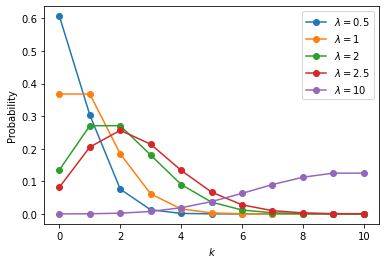

In [6]:
x=np.arange(0,11)
[plt.plot(x,poisson.pmf(x,mu=i),marker = 'o', label ='$\lambda =$'+str(i)) for i in [0.5,1,2,2.5,10]]
plt.legend()
plt.xlabel('$k$')
plt.ylabel('Probability')


Pretty cool, huh? But what does it say? It says that, if we get a team and ask *"what is the probability of
the team score 2 goals ($k = 2$)?"* 

We check that, if $\lambda = 2.5$ (that is, the average number of goals per match based on past World Cups), the probability is approximately 26%. We can say that by looking at the graph above or by computing with the Poisson function:

In [7]:
print("{:.2%}".format(poisson.pmf(k = 2, mu = 2.5)))

25.65%


And just like that, we solved the first problem: We will assume, given two teams, that the team's goal distribution follows the Poisson distribution. That is:
$$
T_1 \sim \text{Pois}(\lambda_1)\\
T_2 \sim \text{Pois}(\lambda_2)
$$
and we will also assume that the teams goals are independent from each other.

Now, to the second problem: how figure it out the average number of goals of each team given a match? Lets jump right into the second problem.

#### Jumping right into the second problem

Well, we don't know how many goals team 1 ($T_1$) has already made to compute its average value, neither for $T_2$, but one thing that we do know is the average value of goals per match from past World Cups (I already told you that!). But, what I didn't told you is that, given the proximity between arenas for the matches, teams won't need to travel much from game to game. This could increase each team's performance. With that said, I will give a 10% increase to the average number of goals per match, resulting in $2.75$. Since this is the expected value per game, and since two teams play in a game, the average value of goals per match will be given by:
$$
\lambda = 2.75 = \lambda_1 + \lambda_2 
$$
with $\lambda_n$ being the average number of goals per match by $T_n$.

This average value will end up being used as the $\lambda$ in the Poisson distribution for each team, so that is why we will call it as $\lambda$. Now, to compute each $\lambda_n$, we will apply a weight for each team based on FIFA's ranking, such that
$$
\lambda_1 = \frac{\lambda \times W_1}{(W_1+W_2)} \quad \text{and} \quad \lambda_2 = \lambda - \lambda_1
$$
with $W_n$ being the weight for $T_n$.

This says that, if $ W_1 > W_2 $, then the average number of goals per match for team 1 will be greater than for team 2. Lets see an example with numbers: *assuming $W_1 = 0.55$, and $W_2 = 0.2$, then*
$$
\lambda_1 = \frac{2.75 \times 0.55}{0.55+0.2} = 2.75 \times 0.733 \approx 2.02 \quad \text{and} \quad \lambda_2 \approx 0.73
$$
meaning that, in average, the number of goals $T_1$ will be of $73\%$ of $2.75$, or 2 goals per game, and for $T_2$ the average number of goals will be of $27\% (1-0.733\approx 0.27)$ of $2.75$, that is $0.73$ goals per game, in a match between the two teams. The team's probability distribution of goals will be given each by its respective Poisson distribution. For $T_1$, we can see in the figure above that a Poisson with $\lambda = 2$ will have max probability in $P(k=1)=P(k=2)=27.07\%$, or by calling:

In [8]:
print("{:.2%}".format(poisson.pmf(k = 2, mu = 2)),"{:.2%}".format(poisson.pmf(k = 1, mu = 2)))

27.07% 27.07%


Okay, that is great! Now lets get to work! We've solved the two problems, now we need to select FIFA's ranking and normalize the data. This ranking is *PontosRankingFIFA* column, which gives the weight of each team. Lets see it:

In [32]:
fifa = pd.DataFrame(teams['FIFAsRankingPoints'])
fifa

,FIFAsRankingPoints
Teams_BR,
Catar,1442
Equador,1464
Senegal,1585
Holanda,1679
Inglaterra,1737
Irã,1559
Estados Unidos,1635
País de Gales,1582
Argentina,1771


To normalize it, we call *sklearn* library, specifically: *MinMaxScaler*. This will normally scale our data from 0 (lowest team) to 1 (highest team), but that would be a problem, because the lowest team will never have a chance of winning (see equation for $\lambda_n$). So, we specify a min value, that will be $0.15$, based on statistics! (trust me, I'm a real ~~doctor~~ master!)

In [33]:
from sklearn.preprocessing import MinMaxScaler 
minmax = MinMaxScaler(feature_range=(0.15,1))   # we need to set a minimun for Gana, otherwise will be 0 
                                                # and will never have a chance to win a game

In [34]:
fifa_norm = minmax.fit_transform(fifa.values.reshape(-1,1))


In [35]:
fifa.insert(1,"FIFAsRankingPointsNorm", fifa_norm.flatten(), True)

Our rank looks like this now:

In [36]:
fifa

,FIFAsRankingPoints,FIFAsRankingPointsNorm
Teams_BR,,
Catar,1442,0.243596
Equador,1464,0.285618
Senegal,1585,0.516742
Holanda,1679,0.696292
Inglaterra,1737,0.807079
Irã,1559,0.467079
Estados Unidos,1635,0.612247
País de Gales,1582,0.511011
Argentina,1771,0.872022


And to work with it, lets just select the normalized column.

In [37]:
weights = fifa['FIFAsRankingPointsNorm']
weights

Teams_BR
Catar             0.243596
Equador           0.285618
Senegal           0.516742
Holanda           0.696292
Inglaterra        0.807079
Irã               0.467079
Estados Unidos    0.612247
País de Gales     0.511011
Argentina         0.872022
Arábia Saudita    0.232135
México            0.640899
Polônia           0.442247
França            0.860562
Dinamarca         0.669551
Tunísia           0.369663
Austrália         0.323820
Espanha           0.768876
Alemanha          0.658090
Japão             0.459438
Costa Rica        0.354382
Bélgica           0.969438
Canadá            0.304719
Marrocos          0.465169
Croácia           0.606517
Brasil            1.000000
Sérvia            0.449888
Suíça             0.585506
Camarões          0.325730
Portugal          0.696292
Gana              0.150000
Uruguai           0.623708
Coreia do Sul     0.404045
Name: FIFAsRankingPointsNorm, dtype: float64

Now, lets build the core of the game. We will build many functions, each calling the other. But what we will finally want is the Probability Matrix from two teams. This matrix will tell us how likely is a score for each game. For that, we will need to compute the Poisson probability for each team, the number of goals, the final score with points for each team based on FIFA World Cup (3 for victory, 1 for tie and 0 for defeat), and finally the prob matrix function to give us what we want! So, lets start!

In [38]:
def Result(gols1, gols2):                               # returns game results for team1 
    if gols1 > gols2:
        res = 'V'                                       # victory
    if gols1 < gols2:                           
        res = 'D'                                       # defeat
    if gols1 == gols2:
        res = 'T'                                       # tie
    return res

def PoissonMean(team1, team2):                          # calculates Poisson mean based on weight series
    weight1 = weights[team1]
    weight2 = weights[team2] 
    mgols = 2.75
    l1      = mgols*weight1/(weight1 + weight2)              # calculating lambda_n
    l2      = mgols*weight2/(weight1 + weight2)
    return [l1, l2]
    
def Dist(mean):                                         # returns the prob of certain number of goals
    probs = []
    for i in range(7):                                  # remember Brazil x Germany (0x7)
        probs.append(poisson.pmf(i,mean))
    probs.append(1-sum(probs))
    return pd.Series(probs, index = ['0', '1', '2', '3', '4', '5', '6', '7+'])

def Prob(team1, team2):                                 # propability matrix
    l1, l2 = PoissonMean(team1, team2)
    d1, d2 = Dist(l1), Dist(l2)  
    matriz = np.outer(d1, d2)                           

    victory = np.tril(matriz).sum()-np.trace(matriz)    # triangular lower
    defeat  = np.triu(matriz).sum()-np.trace(matriz)     # triangular upper
    probs   = np.around([victory, 1-(victory+defeat), defeat], 3)     # 1-vic+def is tie!
    probsp  = [f'{100*i:.1f}%' for i in probs]

    names           = ['0', '1', '2', '3', '4', '5', '6', '7+']
    matriz          = pd.DataFrame(matriz, columns = names, index = names)
    matriz.index    = pd.MultiIndex.from_product([[team1], matriz.index])      # to give us team1 and number of goals
    matriz.columns  = pd.MultiIndex.from_product([[team2], matriz.columns]) 
    output          = {'team1': team1, 'team2': team2, 
                    'W1': weights[team1], 'w2': weights[team2], 
                    'lambda1': l1, 'lambda2': l2, 
                    'probabilities': probsp, 'matrix': matriz}
    return output

def Points(gols1, gols2):                               # gives the score for each team after the game
    rst = Result(gols1, gols2)
    if rst == 'V':
        points1, points2 = 3, 0
    if rst == 'E':
        points1, points2 = 1, 1
    if rst == 'T':
        points1, points2 = 0, 3
    return points1, points2, rst


def Game(team1, team2):                                 
    l1, l2  = PoissonMean(team1, team2)
    gols1   = int(np.random.poisson(lam = l1, size = 1))
    gols2   = int(np.random.poisson(lam = l2, size = 1))
    saldo1  = gols1 - gols2
    saldo2  = -saldo1
    points1, points2, result = Points(gols1, gols2)
    score   = '{}x{}'.format(gols1, gols2)
    return [gols1, gols2, saldo1, saldo2, points1, points2, result, score]

Phew! That was a lot. But now, we can give our estimates for each match. Lets see, say, Argentina x Germany:

In [41]:
Prob('Argentina','Alemanha')

{'team1': 'Argentina',
 'team2': 'Alemanha',
 'W1': 0.8720224719101122,
 'w2': 0.6580898876404495,
 'lambda1': 1.5672455573505653,
 'lambda2': 1.1827544426494347,
 'probabilities': ['46.2%', '25.0%', '28.8%'],
 'matrix':               Alemanha                                                    \
                      0         1         2         3         4         5   
 Argentina 0   0.063928  0.075611  0.044715  0.017629  0.005213  0.001233   
           1   0.100191  0.118501  0.070079  0.027629  0.008169  0.001932   
           2   0.078512  0.092860  0.054915  0.021650  0.006402  0.001514   
           3   0.041016  0.048511  0.028689  0.011311  0.003344  0.000791   
           4   0.016070  0.019007  0.011241  0.004432  0.001310  0.000310   
           5   0.005037  0.005958  0.003523  0.001389  0.000411  0.000097   
           6   0.001316  0.001556  0.000920  0.000363  0.000107  0.000025   
           7+  0.000364  0.000431  0.000255  0.000100  0.000030  0.000007   
 
        

And with that, we see that Argentina has a $46\%$ chance of winning, $25\%$ of a tie and $28\%$ of losing.

Okay! We have this great code to predict our games? But how predict all games from the World Cup? Lets see right now.

---
## Task 1: **Predicting games results!**


Remember that we've selected another data set? I do: games!

In [42]:
games

,data,hora,grupo,seleção1,seleção2,estádio
0,2022-11-21,07:00:00,A,Senegal,Holanda,AL THUMAMA
1,2022-11-21,13:00:00,A,Catar,Equador,AL KHOR
2,2022-11-25,10:00:00,A,Catar,Senegal,AL THUMAMA
3,2022-11-25,13:00:00,A,Holanda,Equador,INTER. KHALIFA
4,2022-11-29,12:00:00,A,Holanda,Catar,AL KHOR
5,2022-11-29,12:00:00,A,Equador,Senegal,INTER. KHALIFA
6,2022-11-21,10:00:00,B,Inglaterra,Irã,INTER. KHALIFA
7,2022-11-21,16:00:00,B,Estados Unidos,País de Gales,AL RAYYAN
8,2022-11-25,07:00:00,B,País de Gales,Irã,AL RAYYAN
9,2022-11-25,16:00:00,B,Inglaterra,Estados Unidos,AL KHOR


This data set tell us all the games, and we have a function to predict each game result... so, what are we waiting for? Lets code these results!

In [43]:
games['Victory']    = None
games['Tie']        = None
games['Defeat']     = None

for i in range(games.shape[0]):
    team1 = games['seleção1'][i]
    team2 = games['seleção2'][i]
    v, t, d = Prob(team1, team2)['probabilities']
    games.at[i,'Victory']   = v
    games.at[i,'Tie']       = t
    games.at[i,'Defeat']    = d

games.to_excel('data/outputEstimativasJogosCopa.xlsx', index = False)
games

,data,hora,grupo,seleção1,seleção2,estádio,Victory,Tie,Defeat
0,2022-11-21,07:00:00,A,Senegal,Holanda,AL THUMAMA,28.3%,24.9%,46.8%
1,2022-11-21,13:00:00,A,Catar,Equador,AL KHOR,32.3%,25.4%,42.3%
2,2022-11-25,10:00:00,A,Catar,Senegal,AL THUMAMA,17.2%,22.1%,60.6%
3,2022-11-25,13:00:00,A,Holanda,Equador,INTER. KHALIFA,64.4%,21.0%,14.6%
4,2022-11-29,12:00:00,A,Holanda,Catar,AL KHOR,68.4%,19.6%,12.0%
5,2022-11-29,12:00:00,A,Equador,Senegal,INTER. KHALIFA,20.7%,23.3%,56.0%
6,2022-11-21,10:00:00,B,Inglaterra,Irã,INTER. KHALIFA,54.6%,23.6%,21.8%
7,2022-11-21,16:00:00,B,Estados Unidos,País de Gales,AL RAYYAN,43.0%,25.3%,31.7%
8,2022-11-25,07:00:00,B,País de Gales,Irã,AL RAYYAN,40.1%,25.5%,34.4%
9,2022-11-25,16:00:00,B,Inglaterra,Estados Unidos,AL KHOR,46.1%,25.0%,28.9%


In [44]:
games.iloc[40]

data        2022-12-02 00:00:00
hora                   16:00:00
grupo                         G
seleção1               Camarões
seleção2                 Brasil
estádio             NAC. LUSAIL
Victory                   11.0%
Tie                       19.0%
Defeat                    70.0%
Name: 40, dtype: object

Ta-da! And that is our prediction for all World Cup games! 

This is also available as a API!

But why stop there? Lets predict all World Cup!

## Task 2: **Predict the whole World Cup!**

Soon
